In [580]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import os
import Image_prep
import importlib
importlib.reload(Image_prep)
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [540]:
#Initially we have the data grouped in two directories corresponding to each of the classes
mask_dir="facemask_images/with_mask"
nomask_dir="facemask_images/without_mask"

In [541]:
#We need to run the line below only once to create train and test folders that included foders for each of the two classes
#Image_prep.train_test_data_sep("facemask_images","with_mask","without_mask",test_fraction=0.3)

In [542]:
train_dir="facemask_images/train/"
test_dir="facemask_images/valid/"

In [543]:
#Get average height and width of the images to choose optimal size

In [544]:
Image_prep.calculate_average_pixel_size(test_dir+"without_mask")

Average image size: 324.41747572815535 x 392.41747572815535 pixels


In [545]:
Image_prep.calculate_average_pixel_size(test_dir+"with_mask")

Average image size: 341.96634615384613 x 401.6682692307692 pixels


In [546]:
# we need to resize all the images to the same size for training of the model
image_shape=(300,300,3)

In [547]:
#Lets display one of the images
os.listdir(test_dir+"with_mask")[0]

'0-with-mask.jpg'

In [548]:
im_mask=plt.imread(test_dir+"with_mask/0-with-mask.jpg")

In [549]:
im_mask.shape

(350, 525, 3)

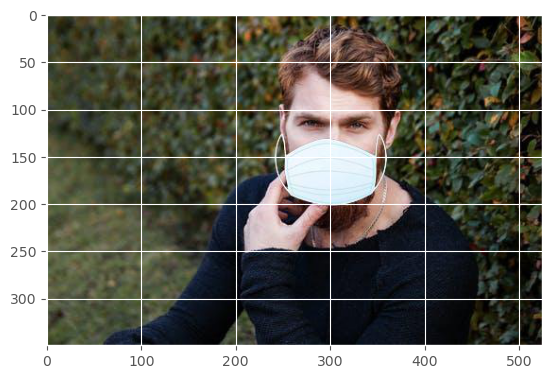

In [550]:
plt.imshow(im_mask)

# Model

In [551]:
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [552]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 35, 35, 32)      

In [553]:
early_stop=EarlyStopping(monitor="val_loss",patience=2)

In [554]:
batch_size=16 #power of two

In [555]:
#Defining data generators to read the pictures and store in float32 tensors
image_gen=ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1, #cutting away part of the image
                             zoom_range=0.1,
                             horizontal_flip=True, #randomly allow horizontal flipping
                             fill_mode="nearest", # if you are stretching pictue use numbers in neighbouring cells
                             rescale=1/255  # need this to normalize image 0-255 to be 0-1 
                             )  #expand amount of images: rotate randomly images for up to 20 Deg, shifth the width of the image randomly up to 10%

In [556]:
train_image_gen=image_gen.flow_from_directory(train_dir,
                                              target_size=image_shape[:2],
                                              color_mode="rgb",
                                              batch_size=batch_size,
                                            class_mode="binary") #shuffling to avoid any overfitting in training

Found 962 images belonging to 2 classes.


In [557]:
test_image_gen=image_gen.flow_from_directory(test_dir,
                                              target_size=image_shape[:2],
                                              color_mode="rgb",
                                             batch_size=batch_size,
                                             class_mode="binary",
                                             shuffle=False) #during inference (validation/test) there is no training thus no shuffling.

Found 414 images belonging to 2 classes.


In [558]:
train_image_gen.class_indices

{'with_mask': 0, 'without_mask': 1}

In [559]:
results=model.fit_generator(train_image_gen,epochs=20,
                           validation_data=test_image_gen,
                           callbacks=[early_stop])

C:\Users\17573\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
61/61 [==============================] - 49s 800ms/step - loss: 0.4494 - accuracy: 0.7765 - val_loss: 0.1928 - val_accuracy: 0.9420
Epoch 2/20
61/61 [==============================] - 49s 805ms/step - loss: 0.2177 - accuracy: 0.9293 - val_loss: 0.0951 - val_accuracy: 0.9638
Epoch 3/20
61/61 [==============================] - 49s 805ms/step - loss: 0.1325 - accuracy: 0.9501 - val_loss: 0.1129 - val_accuracy: 0.9565
Epoch 4/20
61/61 [==============================] - 51s 834ms/step - loss: 0.1505 - accuracy: 0.9574 - val_loss: 0.1428 - val_accuracy: 0.9469


In [560]:
losses=pd.DataFrame(model.history.history)

In [581]:
eval_obj=Image_prep.model_eval(model,test_image_gen)

26/26 [==============================] - 9s 344ms/step
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       208
           1       0.98      0.89      0.94       206

    accuracy                           0.94       414
   macro avg       0.94      0.94      0.94       414
weighted avg       0.94      0.94      0.94       414



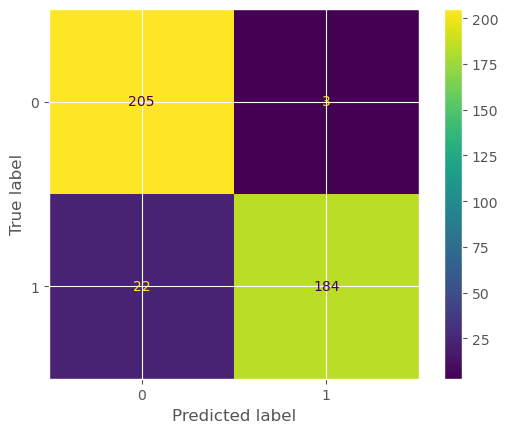

In [562]:
eval_obj.model_pred()

Plotting image for lossesIndex(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')


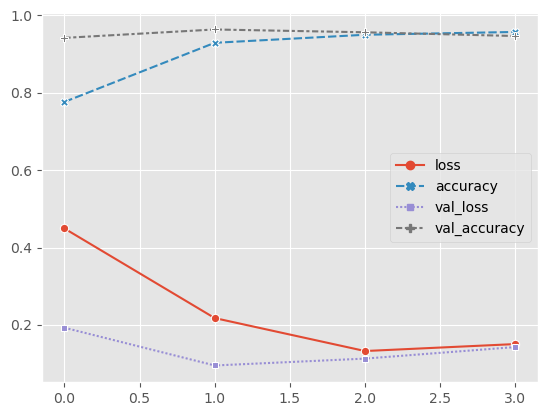

In [563]:
eval_obj.loss_plot(losses)

In [582]:
mask_cell=test_dir+"with_mask/0-with-mask.jpg"

1/1 [==============================] - 0s 28ms/step


{'with_mask'}

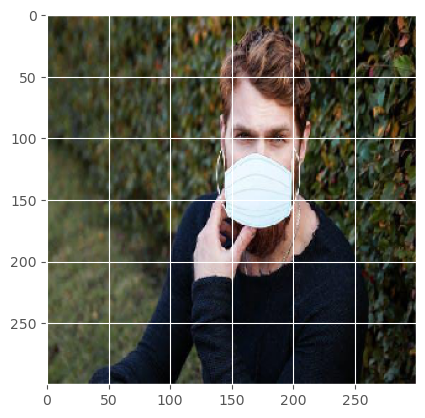

In [583]:
eval_obj.pred_img_class(mask_cell,image_shape)

In [566]:
model.save("Mask_model.h5")